# Initialization

## Load and Split Dataset

In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,Nadam,RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Reshape, BatchNormalization, Dropout

knn = KNeighborsClassifier(n_neighbors=3)

In [3]:
import zipfile
# Install Kaggle API
!pip install -q kaggle

# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"  # Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = "your_kaggle_key"  # Replace with your Kaggle API key

# Download CASIA-WebFace dataset
!kaggle datasets download -d ntl0601/casia-webface

# Extract dataset
zip_path = "casia-webface.zip"
extract_path = "./casia_webface_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Dataset URL: https://www.kaggle.com/datasets/ntl0601/casia-webface
License(s): unknown
 99% 2.51G/2.53G [00:13<00:00, 276MB/s]
100% 2.53G/2.53G [00:13<00:00, 200MB/s]


In [4]:
# Update the data directory to point to the extracted 'casia-webface'
data_dir = os.path.join(extract_path, "casia-webface")

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Lists to hold images and labels
train_images, train_labels = [], []
val_images, val_labels = [], []
test_images, test_labels = [], []

# Collect classes with at least 200 images
eligible_classes = [
    class_name for class_name in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, class_name)) and \
       len([img for img in os.listdir(os.path.join(data_dir, class_name)) if os.path.isfile(os.path.join(data_dir, class_name, img))]) >= 200
]

# Limit to 51 classes
selected_classes = sorted(eligible_classes)[:51]

# Split data for each class (identity)
for class_name in selected_classes:
    class_path = os.path.join(data_dir, class_name)

    # Get all images for the current class
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

    # Split into train, validation, and test
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    # Load images and labels for each set (train, val, test)
    for img_path in train_imgs:
        img = load_img(img_path, target_size=(64, 64), color_mode="rgb")
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        train_images.append(img_array)
        train_labels.append(class_name)

    for img_path in val_imgs:
        img = load_img(img_path, target_size=(64, 64), color_mode="rgb")
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        val_images.append(img_array)
        val_labels.append(class_name)

    for img_path in test_imgs:
        img = load_img(img_path, target_size=(64, 64), color_mode="rgb")
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        test_images.append(img_array)
        test_labels.append(class_name)

# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Ensure labels are NumPy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# Print dataset shapes
print(f"Training set shape: {train_images.shape}")
print(f"Validation set shape: {val_images.shape}")
print(f"Test set shape: {test_images.shape}")
# Print label shapes
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")



Training set shape: (11088, 64, 64, 3)
Validation set shape: (3179, 64, 64, 3)
Test set shape: (1618, 64, 64, 3)
Training labels shape: (11088,)
Validation labels shape: (3179,)
Test labels shape: (1618,)


## Visualization

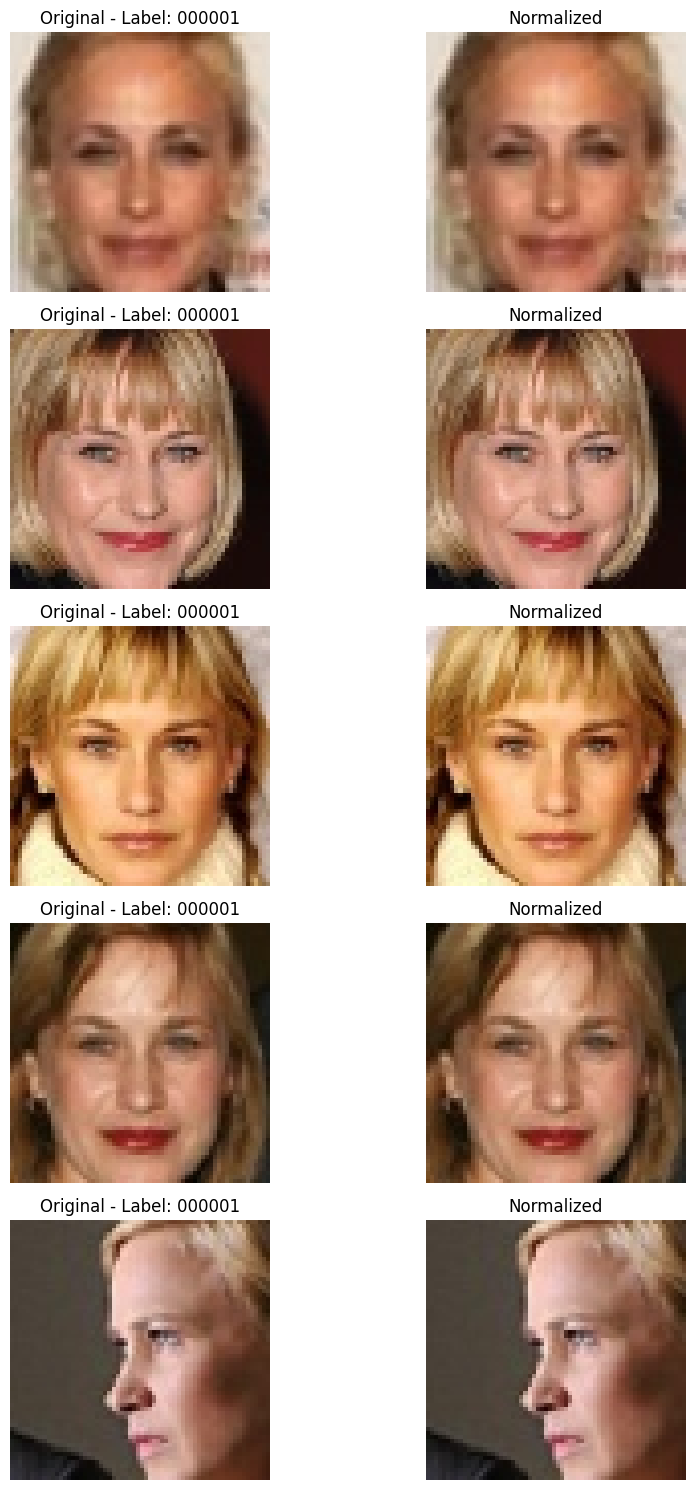

In [36]:
import matplotlib.pyplot as plt

# Function to visualize images before and after normalization
def visualize_images(images, labels, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    for i in range(num_images):
        # Original image
        img_array_original = images[i] * 255  # De-normalize for visualization
        img_array_normalized = images[i]      # Normalized image

        # Display original image
        axes[i, 0].imshow(img_array_original.astype('uint8'))
        axes[i, 0].set_title(f"Original - Label: {labels[i]}")
        axes[i, 0].axis("off")

        # Display normalized image
        axes[i, 1].imshow(img_array_normalized)
        axes[i, 1].set_title("Normalized")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize a few images from the training set
visualize_images(train_images, train_labels, num_images=5)


## Functions

In [5]:
# Function to plot accuracy and loss vs. epochs
def plot_training_metrics(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


# Function to plot accuracy and loss vs. epochs
def plot_training_metrics2(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Visualize reconstructed images
def visualize_reconstruction(model, original, title, img_shape=(64, 64, 3)):
    reconstructed = model.predict(original)
    plt.figure(figsize=(12, 6))
    for i in range(5):
        # Original image
        plt.subplot(2, 5, i + 1)
        plt.imshow(original[i].reshape(img_shape))
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed[i].reshape(img_shape))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_predictions(test_images, test_true_labels, test_predictions_labels, num_images_to_display=10):
    """
    Visualize random test images with their predicted and true labels.

    Parameters:
    - test_images: Array of test images.
    - test_true_labels: Array of true labels for the test images.
    - test_predictions_labels: Array of predicted labels for the test images.
    - num_images_to_display: Number of images to display (default is 10).
    """
    # Select random indices from the test set
    random_indices = random.sample(range(len(test_images)), num_images_to_display)

    # Create a plot for the selected images
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        # Retrieve the image, true label, and predicted label
        image = test_images[idx]  # Assuming test_images contains the original test images
        true_label = test_true_labels[idx]
        predicted_label = test_predictions_labels[idx]

        # Plot the image
        plt.subplot(2, 5, i + 1)  # Create a grid of 2x5
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)  # Add true and predicted labels
        plt.axis('off')  # Turn off axes for cleaner visualization

    # Adjust layout
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(test_true_labels, test_predicted_labels, title="Confusion Matrix", figsize=(10, 10)):
    """
    Plot a confusion matrix with values displayed in each cell.

    Parameters:
    - test_true_labels: Array of true labels.
    - test_predicted_labels: Array of predicted labels.
    - title: Title of the confusion matrix plot (default: "Confusion Matrix").
    - figsize: Size of the figure (default: (10, 10)).
    """
    # Compute confusion matrix
    cm = confusion_matrix(test_true_labels, test_predicted_labels)

    # Create the plot
    plt.figure(figsize=figsize)
    plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)  # Display the confusion matrix with a color map
    plt.colorbar()  # Add a color bar to show the scale

    # Remove axis ticks and labels
    plt.xticks([])
    plt.yticks([])

    # Display values in the matrix
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black')

    # Add title
    plt.title(title, pad=20, fontsize=16)
    plt.show()


def visualize_model_accuracies(model_names, accuracies, title="Model Accuracy Comparison"):
    """
    Visualize model accuracies using a bar chart.

    Parameters:
    - model_names: List of model names (e.g., ["MLP", "CNN", "Eigenfaces"])
    - accuracies: List of accuracies corresponding to the models
    - title: Title of the plot (default: "Model Accuracy Comparison")
    """
    # Convert accuracies to percentages if needed
    accuracies = [acc * 100 for acc in accuracies]

    # Create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'], alpha=0.7)

    # Add labels and title
    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.title(title, fontsize=16)
    plt.ylim(0, 100)  # Ensure the y-axis spans from 0 to 100 for percentages

    # Add accuracy values on top of bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()


## Encoding labels and Images Flatten

In [6]:
# Function to preprocess data (reshape and encode labels)
def preprocess_data_for_mlp(train_images, val_images, test_images, train_labels, val_labels, test_labels):
    # Flatten images for MLP
    train_images_mlp = train_images.reshape(train_images.shape[0], -1)
    val_images_mlp = val_images.reshape(val_images.shape[0], -1)
    test_images_mlp = test_images.reshape(test_images.shape[0], -1)

    # Ensure labels are in 1D (class indices)
    train_labels_flatten = np.array(train_labels).flatten()
    val_labels_flatten = np.array(val_labels).flatten()
    test_labels_flatten = np.array(test_labels).flatten()

    # Encode labels using LabelEncoder
    label_encoder = LabelEncoder()
    train_labels_encoder = label_encoder.fit_transform(train_labels_flatten)
    val_labels_encoder = label_encoder.transform(val_labels_flatten)
    test_labels_encoder = label_encoder.transform(test_labels_flatten)

    # One-hot encode labels (for model training)
    num_classes = len(label_encoder.classes_)
    train_labels_onehot = to_categorical(train_labels_encoder, num_classes)
    val_labels_onehot = to_categorical(val_labels_encoder, num_classes)
    test_labels_onehot = to_categorical(test_labels_encoder, num_classes)

    return train_images_mlp, val_images_mlp, test_images_mlp, train_labels_onehot, val_labels_onehot, test_labels_onehot, num_classes

# Function to preprocess data for CNN (reshape and encode labels)
def preprocess_data_for_cnn(train_images, val_images, test_images, train_labels, val_labels, test_labels, img_size=(64, 64)):
    # Reshape images for CNN input (adding channel dimension)
    train_images_cnn = train_images.reshape(train_images.shape[0], img_size[0], img_size[1], 3)
    val_images_cnn = val_images.reshape(val_images.shape[0], img_size[0], img_size[1], 3)
    test_images_cnn = test_images.reshape(test_images.shape[0], img_size[0], img_size[1], 3)

    # Ensure labels are in 1D (class indices)
    train_labels_flatten = np.array(train_labels).flatten()
    val_labels_flatten = np.array(val_labels).flatten()
    test_labels_flatten = np.array(test_labels).flatten()

    # Encode labels using LabelEncoder
    label_encoder = LabelEncoder()
    train_labels_encoder = label_encoder.fit_transform(train_labels_flatten)
    val_labels_encoder = label_encoder.transform(val_labels_flatten)
    test_labels_encoder = label_encoder.transform(test_labels_flatten)

    # One-hot encode labels (for model training)
    num_classes = len(label_encoder.classes_)
    train_labels_onehot = to_categorical(train_labels_encoder, num_classes)
    val_labels_onehot = to_categorical(val_labels_encoder, num_classes)
    test_labels_onehot = to_categorical(test_labels_encoder, num_classes)

    return train_images_cnn, val_images_cnn, test_images_cnn, train_labels_onehot, val_labels_onehot, test_labels_onehot, num_classes

def preprocess_data_for_eigenfaces(train_images, val_images, test_images, train_labels, val_labels, test_labels, n_components=50):
    # Flatten images for PCA
    train_images_flat = train_images.reshape(train_images.shape[0], -1)
    val_images_flat = val_images.reshape(val_images.shape[0], -1)
    test_images_flat = test_images.reshape(test_images.shape[0], -1)

    # Ensure labels are in 1D (class indices)
    train_labels_flatten = np.array(train_labels).flatten()
    val_labels_flatten = np.array(val_labels).flatten()
    test_labels_flatten = np.array(test_labels).flatten()

    # Encode labels using LabelEncoder
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels_flatten)
    val_labels_encoded = label_encoder.transform(val_labels_flatten)
    test_labels_encoded = label_encoder.transform(test_labels_flatten)

    # One-hot encode labels (for model training)
    num_classes = len(label_encoder.classes_)
    train_labels_onehot = to_categorical(train_labels_encoded, num_classes)
    val_labels_onehot = to_categorical(val_labels_encoded, num_classes)
    test_labels_onehot = to_categorical(test_labels_encoded, num_classes)

    return train_images_flat, val_images_flat, test_images_flat, train_labels_onehot, val_labels_onehot, test_labels_onehot, num_classes


# Preprocess data for Eigenfaces
train_images_eigen, val_images_eigen, test_images_eigen, train_labels_eigen, val_labels_eigen, test_labels_eigen, num_classes_eigen = preprocess_data_for_eigenfaces(
    train_images, val_images, test_images, train_labels, val_labels, test_labels
)

# Preprocess data for MLP and CNN
train_images_mlp, val_images_mlp, test_images_mlp, train_labels_mlp, val_labels_mlp, test_labels_mlp, num_classes_mlp = preprocess_data_for_mlp(
    train_images, val_images, test_images, train_labels, val_labels, test_labels
)

train_images_cnn, val_images_cnn, test_images_cnn, train_label_cnn, val_labels_cnn, test_labels_cnn, num_classes_cnn = preprocess_data_for_cnn(
    train_images, val_images, test_images, train_labels, val_labels, test_labels
)

# Verify the shapes after preprocessing
print("MLP Preprocessed Data Shapes:")
print("Training Images (MLP) shape:", train_images_mlp.shape)
print("Validation Images (MLP) shape:", val_images_mlp.shape)
print("Test Images (MLP) shape:", test_images_mlp.shape)
print(f"Train Labels (MLP): {train_labels_mlp.shape}")
print(f"Validation Labels (MLP): {val_labels_mlp.shape}")
print(f"Test Labels (MLP): {test_labels_mlp.shape}")

print("\nCNN Preprocessed Data Shapes:")
print("Training Images (CNN) shape:", train_images_cnn.shape)
print("Validation Images (CNN) shape:", val_images_cnn.shape)
print("Test Images (CNN) shape:", test_images_cnn.shape)
print(f"Train Labels (CNN): {train_label_cnn.shape}")
print(f"Validation Labels (CNN): {val_labels_cnn.shape}")
print(f"Test Labels (CNN): {test_labels_cnn.shape}")

print("\nEigenfaces Preprocessed Data Shapes:")
print("Training Images shape:", train_images_eigen.shape)
print("Validation Images shape:", val_images_eigen.shape)
print("Test Images shape:", test_images_eigen.shape)
print(f"Train Labels (PCA): {train_labels_eigen.shape}")
print(f"Validation Labels (PCA): {val_labels_eigen.shape}")
print(f"Test Labels (PCA): {test_labels_eigen.shape}")


MLP Preprocessed Data Shapes:
Training Images (MLP) shape: (11088, 12288)
Validation Images (MLP) shape: (3179, 12288)
Test Images (MLP) shape: (1618, 12288)
Train Labels (MLP): (11088, 51)
Validation Labels (MLP): (3179, 51)
Test Labels (MLP): (1618, 51)

CNN Preprocessed Data Shapes:
Training Images (CNN) shape: (11088, 64, 64, 3)
Validation Images (CNN) shape: (3179, 64, 64, 3)
Test Images (CNN) shape: (1618, 64, 64, 3)
Train Labels (CNN): (11088, 51)
Validation Labels (CNN): (3179, 51)
Test Labels (CNN): (1618, 51)

Eigenfaces Preprocessed Data Shapes:
Training Images shape: (11088, 12288)
Validation Images shape: (3179, 12288)
Test Images shape: (1618, 12288)
Train Labels (PCA): (11088, 51)
Validation Labels (PCA): (3179, 51)
Test Labels (PCA): (1618, 51)


# MLP Model

## Encoder Training

Training Encoder-Decoder Model...
Epoch 1/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8703 - loss: 0.0369 - val_accuracy: 0.8927 - val_loss: 0.0221
Epoch 2/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8928 - loss: 0.0197 - val_accuracy: 0.8851 - val_loss: 0.0165
Epoch 3/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8929 - loss: 0.0150 - val_accuracy: 0.9012 - val_loss: 0.0129
Epoch 4/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8953 - loss: 0.0122 - val_accuracy: 0.8830 - val_loss: 0.0117
Epoch 5/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8971 - loss: 0.0111 - val_accuracy: 0.8930 - val_loss: 0.0109
Epoch 6/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8985 - loss: 0.0102 - val_accuracy: 0.8998 - val_loss: 0.0102
Epoch 7/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8964 - loss: 0.0099 - val_accuracy: 0.8847 - val_loss: 0.0097
Epoch 8/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8

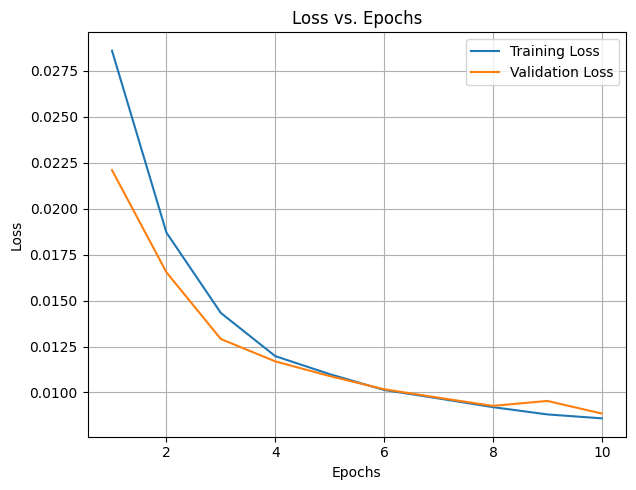

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8958 - loss: 0.0089
MLP Autoencoder Test Loss (MSE): 0.0089
MLP Autoencoder Test Acc (MSE): 0.8926


In [20]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.losses import MeanSquaredError
# Clear previous session
clear_session()

def build_encoder_decoder(input_shape, latent_dim):
    input_img = Input(shape=input_shape, name="Input_Image")

    # Encoder
    x = Flatten()(input_img)  # Flatten the input image
    x = Dense(1024, activation='relu')(x)

    latent = Dense(latent_dim, activation='relu', name="Latent_Space")(x)

    # Decoder
    x = Dense(1024, activation='relu')(latent)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    reconstructed = Reshape(input_shape)(x)

    # Build the model
    autoencoder = Model(inputs=input_img, outputs=reconstructed, name="Autoencoder")
    return autoencoder

# Input Shape
input_shape = (64, 64, 3)
latent_dim = 512  # Increased latent dimension


# Build and Compile
autoencoder = build_encoder_decoder(input_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Step 3: Train Encoder-Decoder
print("Training Encoder-Decoder Model...")
history_mlp=autoencoder.fit(
    train_images, train_images,  # Autoencoder reconstructs input
    validation_data=(val_images, val_images),
    epochs=10,
    batch_size=32
)
plot_training_metrics(history_mlp)

# Evaluate the model on the test set
mlp_test_loss,mlp_test_accuracy= autoencoder.evaluate(
    test_images, test_images, verbose=1
)

# Print the results
print(f"MLP Autoencoder Test Loss (MSE): {mlp_test_loss:.4f}")
print(f"MLP Autoencoder Test Acc (MSE): {mlp_test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


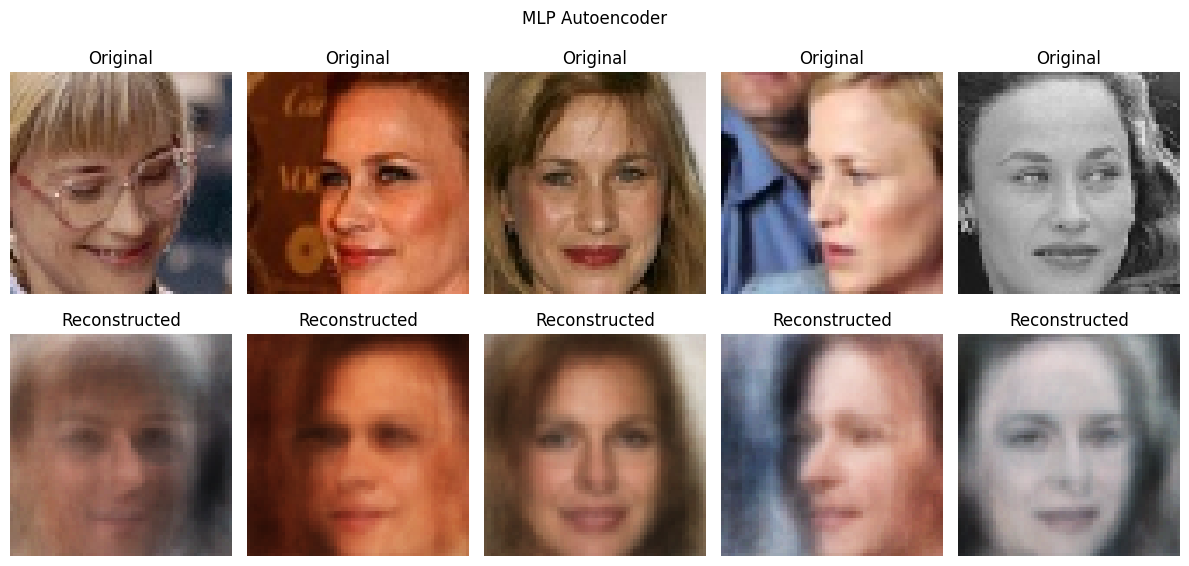

In [21]:
visualize_reconstruction(autoencoder, test_images[5:10], "MLP Autoencoder")

## Features Extraction and Classification

In [22]:
# Step 4: Extract Latent Features
encoder_mlp = Model(
    autoencoder.input,
    autoencoder.get_layer("Latent_Space").output
)

train_features_mlp = encoder_mlp.predict(train_images)
val_features_mlp = encoder_mlp.predict(val_images)
test_features_mlp = encoder_mlp.predict(test_images)
print("Train Features Shape:", train_features_mlp.shape)
print("Validation Features Shape:", val_features_mlp.shape)
print("Test Features Shape:", test_features_mlp.shape)

347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Features Shape: (11088, 512)
Validation Features Shape: (3179, 512)
Test Features Shape: (1618, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Classifier on Latent Features...
Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0546 - loss: 4.0111 - val_accuracy: 0.1664 - val_loss: 3.4021
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1533 - loss: 3.3536 - val_accuracy: 0.2394 - val_loss: 3.0457
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2097 - loss: 3.0750 - val_accuracy: 0.2963 - val_loss: 2.8330
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2591 - loss: 2.8427 - val_accuracy: 0.3190 - val_loss: 2.7217
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2843 - loss: 2.7019 - val_accuracy: 0.3344 - val_loss: 2.6381
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3155 - loss: 2.5887 - val_accuracy: 0.3334 - val_loss: 2.5873
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3233 - loss: 2.5564 - val_accuracy: 0.3570 - val_loss: 2.5163
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3356 - loss

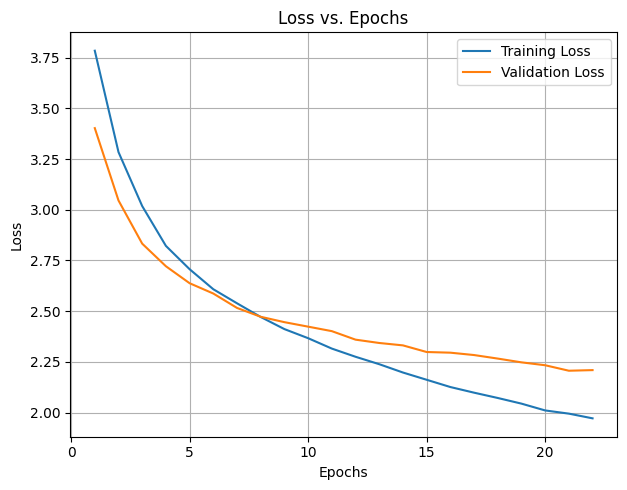

Evaluating Classifier...
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Face Recognition Accuracy: 41.84%


In [32]:
# Step 2: Build Classifier
def build_classifier(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Step 5: Train Classifier on Latent Features
classifier = build_classifier(train_features_mlp.shape[1], num_classes_mlp)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping_mlp = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=1,  # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

print("Training Classifier on Latent Features...")
classifier_mlp=classifier.fit(
    train_features_mlp, train_labels_mlp,
    validation_data=(val_features_mlp, val_labels_mlp),
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping_mlp]
)
plot_training_metrics(classifier_mlp)

# Step 6: Evaluate Recognition Accuracy
print("Evaluating Classifier...")
test_predictions_mlp = classifier.predict(test_features_mlp)
test_predictions_labels_mlp = test_predictions_mlp.argmax(axis=1)
test_true_labels_mlp = test_labels_mlp.argmax(axis=1)

recognition_accuracy_mlp = accuracy_score(test_true_labels_mlp, test_predictions_labels_mlp)
print(f"Face Recognition Accuracy: {recognition_accuracy_mlp * 100:.2f}%")


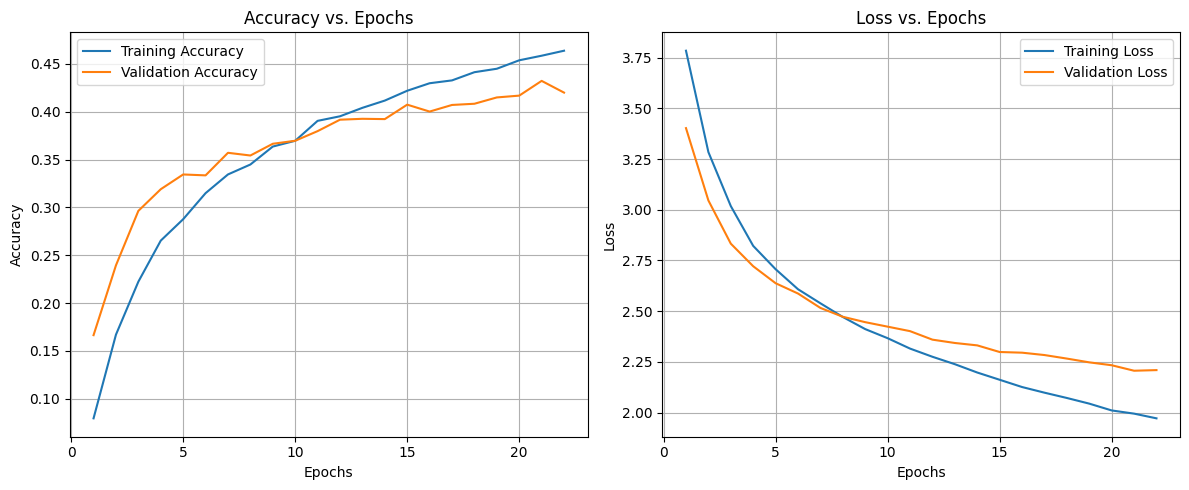

In [33]:
plot_training_metrics2(classifier_mlp)

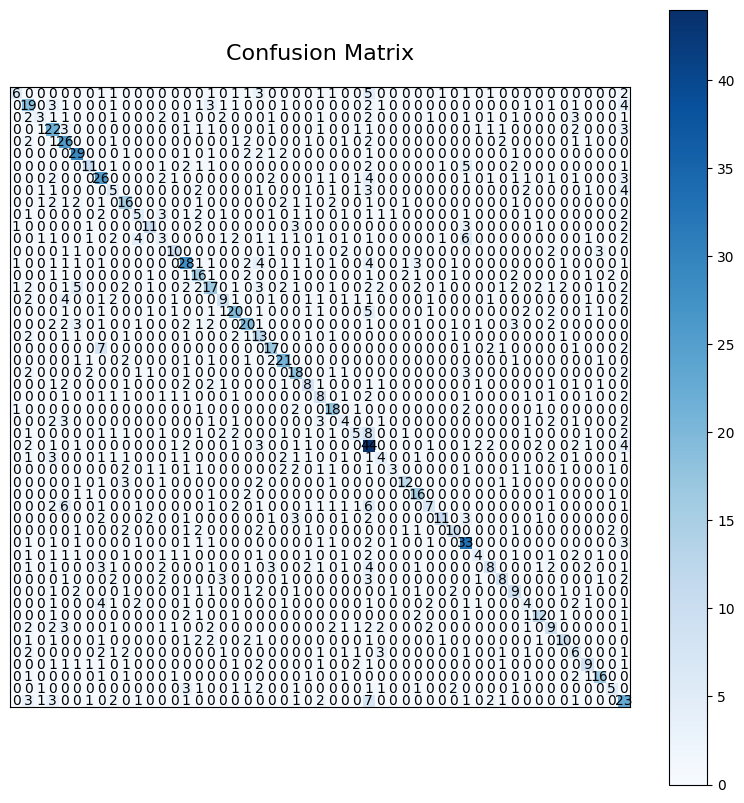

In [34]:
plot_confusion_matrix(test_true_labels_mlp, test_predictions_labels_mlp)

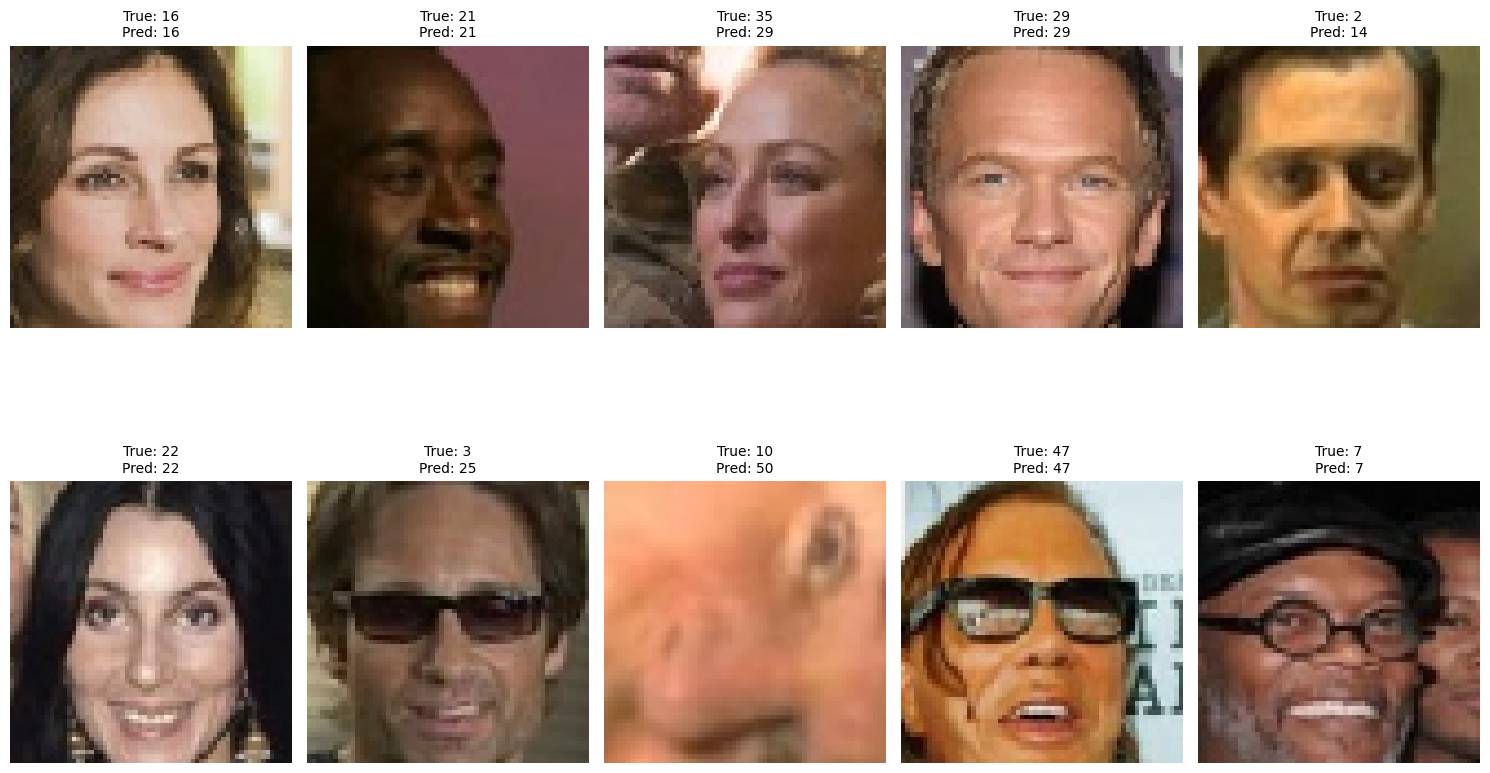

In [38]:
import random
visualize_predictions(test_images, test_true_labels_mlp, test_predictions_labels_mlp, num_images_to_display=10)

# CNN Model

## Encoder Training

Training CNN Encoder-Decoder Model...
Epoch 1/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.8919 - loss: 0.0249 - val_accuracy: 0.9310 - val_loss: 0.0061
Epoch 2/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9162 - loss: 0.0050 - val_accuracy: 0.9159 - val_loss: 0.0041
Epoch 3/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9179 - loss: 0.0038 - val_accuracy: 0.9021 - val_loss: 0.0032
Epoch 4/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9185 - loss: 0.0031 - val_accuracy: 0.9411 - val_loss: 0.0029
Epoch 5/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9215 - loss: 0.0027 - val_accuracy: 0.9389 - val_loss: 0.0027
Epoch 6/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9248 - loss: 0.0025 - val_accuracy: 0.8886 - val_loss: 0.0024
Epoch 7/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9241 - loss: 0.0023 - val_accuracy: 0.9364 - val_loss: 0.0021
Epoch 8/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step 

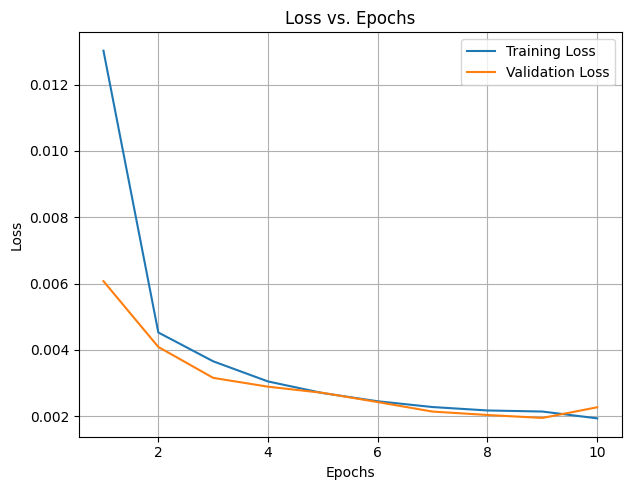

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9185 - loss: 0.0023
CNN Autoencoder Test Loss (MSE): 0.0023
CNN Autoencoder Test Acc (MSE): 0.9185


In [39]:
# Step 1: Build CNN-based Encoder-Decoder Model
def build_cnn_encoder_decoder(input_shape):
    input_img = Input(shape=input_shape, name="Input_Image")

    # Encoder: Convolutional layers to reduce spatial dimensions
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)  # 64 filters, 3x3 kernel
    x = MaxPooling2D((2, 2), padding='same')(x)  # Downsample to 32x32
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Downsample to 16x16
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Downsample to 8x8
    latent_vector = Conv2D(512, (3, 3), activation='relu', padding='same', name="Latent_Representation")(x)  # Latent space (8x8x512)

    # Decoder: Transpose convolutional layers to reconstruct the image
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(latent_vector)
    x = UpSampling2D((2, 2))(x)  # Upsample to 16x16
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Upsample to 32x32
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Upsample to 64x64
    reconstructed = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final reconstruction

    # Build the model
    encoder_decoder_model = Model(inputs=input_img, outputs=reconstructed, name="CNN_Encoder_Decoder_Model")
    return encoder_decoder_model


# Compile the encoder-decoder
encoder_decoder_model_cnn = build_cnn_encoder_decoder((64, 64, 3))
encoder_decoder_model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Step 3: Train Encoder-Decoder
print("Training CNN Encoder-Decoder Model...")
history_cnn = encoder_decoder_model_cnn.fit(
    train_images_cnn, train_images_cnn,  # Autoencoder reconstructs input
    validation_data=(val_images_cnn, val_images_cnn),
    epochs=10,
    batch_size=32
)
plot_training_metrics(history_cnn)


# Evaluate the model on the test set
cnn_test_loss,cnn_test_accuracy = encoder_decoder_model_cnn.evaluate(
    test_images_cnn, test_images_cnn, verbose=1
)

# Print the results
print(f"CNN Autoencoder Test Loss (MSE): {cnn_test_loss:.4f}")
print(f"CNN Autoencoder Test Acc (MSE): {cnn_test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


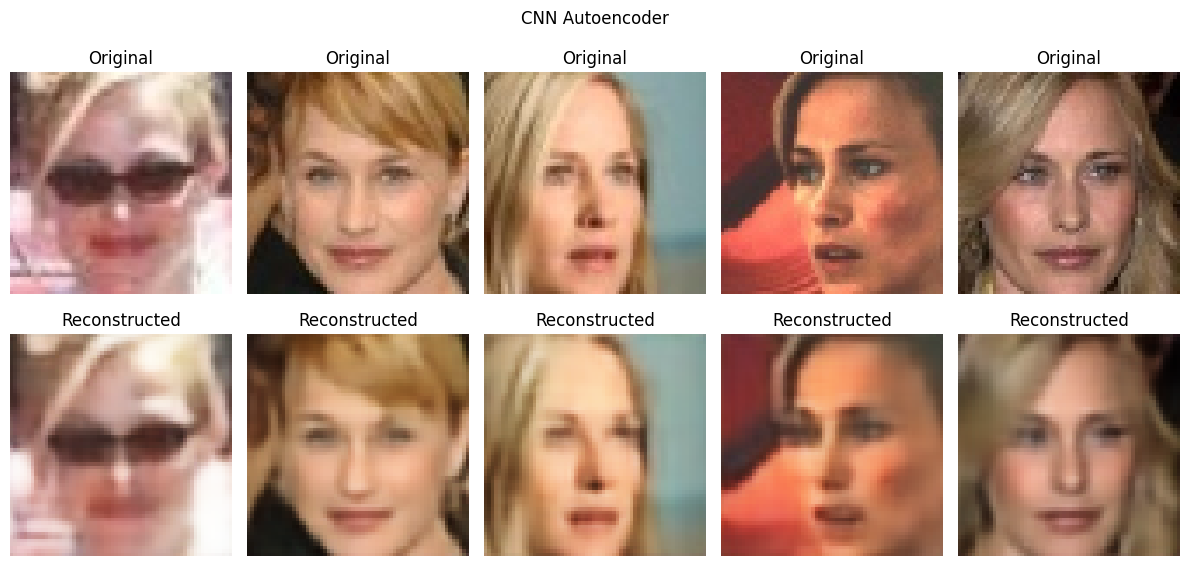

In [40]:
visualize_reconstruction(encoder_decoder_model_cnn, test_images_cnn[10:15], "CNN Autoencoder")

## Features Extraction and Classification

In [41]:
# Step 4: Extract Latent Features
encoder_cnn = Model(
    encoder_decoder_model_cnn.input,
    encoder_decoder_model_cnn.get_layer("Latent_Representation").output
)

train_features_cnn = encoder_cnn.predict(train_images_cnn)
val_features_cnn = encoder_cnn.predict(val_images_cnn)
test_features_cnn = encoder_cnn.predict(test_images_cnn)
print("Train Features Shape:", train_features_cnn.shape)
print("Validation Features Shape:", val_features_cnn.shape)
print("Test Features Shape:", test_features_cnn.shape)


347/347 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Train Features Shape: (11088, 8, 8, 512)
Validation Features Shape: (3179, 8, 8, 512)
Test Features Shape: (1618, 8, 8, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Classifier on Latent Features...
Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.0883 - loss: 3.6773 - val_accuracy: 0.2746 - val_loss: 2.9268
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2782 - loss: 2.8200 - val_accuracy: 0.4605 - val_loss: 2.3525
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4101 - loss: 2.2886 - val_accuracy: 0.5291 - val_loss: 2.0168
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5029 - loss: 1.9369 - val_accuracy: 0.5838 - val_loss: 1.7930
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5718 - loss: 1.6659 - val_accuracy: 0.6059 - val_loss: 1.6485
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6278 - loss: 1.4732 - val_accuracy: 0.6222 - val_loss: 1.5381
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6690 - loss: 1.3171 - val_accuracy: 0.6637 - val_loss: 1.4168
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6913

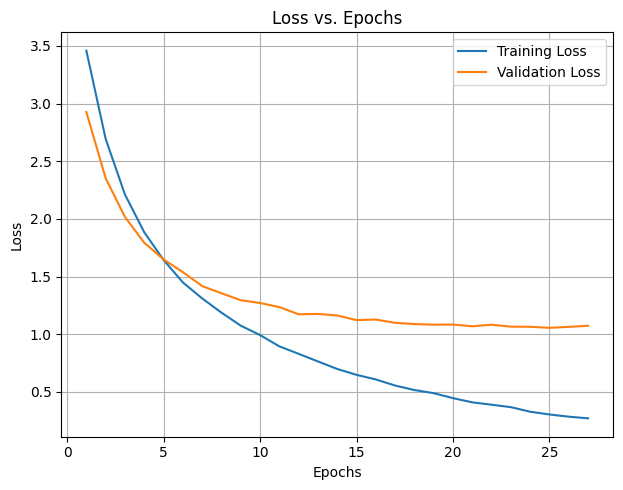

In [47]:
train_features_cnn = train_features_cnn.reshape(train_features_cnn.shape[0], -1)
val_features_cnn = val_features_cnn.reshape(val_features_cnn.shape[0], -1)
test_features_cnn = test_features_cnn.reshape(test_features_cnn.shape[0], -1)

# Step 2: Build Classifier
def build_classifier_cnn(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Step 5: Train Classifier on Latent Features
classifier_cnn = build_classifier_cnn(train_features_cnn.shape[1], num_classes_cnn)
classifier_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping_cnn = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

print("Training Classifier on Latent Features...")
history_cnn2=classifier_cnn.fit(
    train_features_cnn, train_label_cnn,
    validation_data=(val_features_cnn, val_labels_cnn),
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping_cnn]
)

# Step 6: Evaluate Recognition Accuracy
print("Evaluating Classifier...")
test_predictions_cnn = classifier_cnn.predict(test_features_cnn)
test_predictions_labels_cnn = test_predictions_cnn.argmax(axis=1)
test_true_labels_cnn = test_labels_cnn.argmax(axis=1)

recognition_accuracy_cnn = accuracy_score(test_true_labels_cnn, test_predictions_labels_cnn)
print(f"Face Recognition Accuracy: {recognition_accuracy_cnn * 100:.2f}%")

# Call the plot function with the training history
plot_training_metrics(history_cnn2)

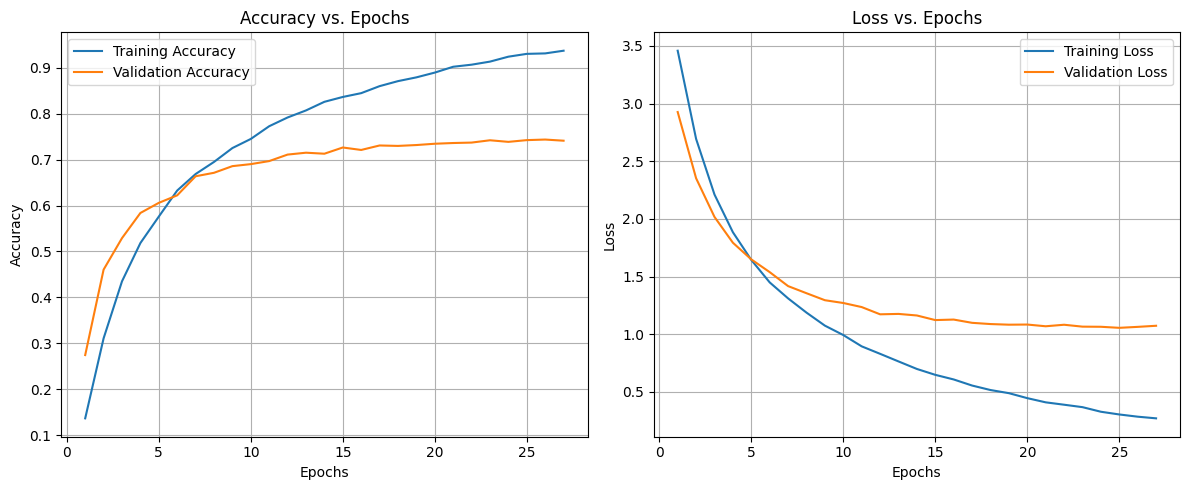

In [48]:
plot_training_metrics2(history_cnn2)

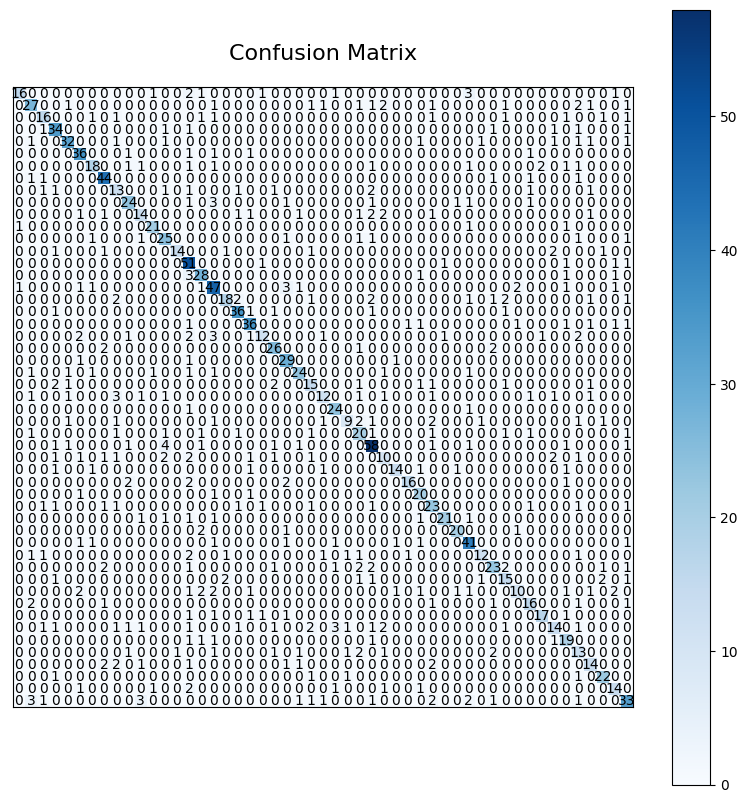

In [49]:
plot_confusion_matrix(test_true_labels_cnn, test_predictions_labels_cnn)

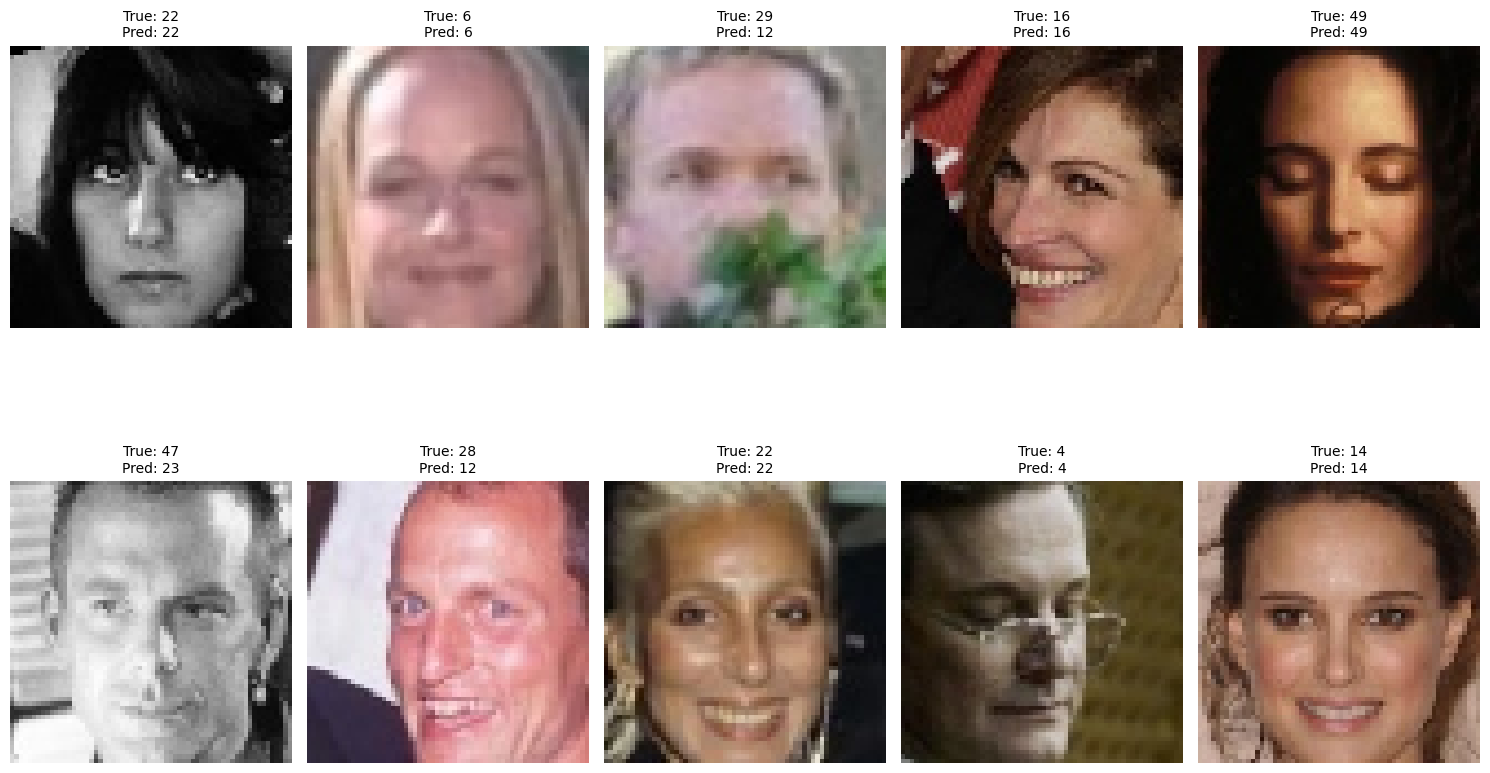

In [50]:
visualize_predictions(test_images, test_true_labels_cnn, test_predictions_labels_cnn, num_images_to_display=10)

# Eigenfaces (PCA)

## Features Extraction

In [ ]:
pca = PCA()
pca.fit(train_images_eigen)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain 95% variance
n_components_95 = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")


Number of components explaining 95% variance: 261


In [70]:
# Perform PCA for Eigenfaces
pca = PCA(n_components=1000)  # Use 1000 components
train_pca = pca.fit_transform(train_images_eigen)
test_pca = pca.transform(test_images_eigen)
val_pca = pca.transform(val_images_eigen)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by 1000 components: {explained_variance_ratio[999]}")


Variance explained by 1000 components: 0.9872525930404663


## Classification

Training Classifier on Latent Features...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.0351 - loss: 5.0517 - val_accuracy: 0.2428 - val_loss: 3.2368
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1256 - loss: 3.6635 - val_accuracy: 0.3853 - val_loss: 2.8301
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2326 - loss: 3.0414 - val_accuracy: 0.4706 - val_loss: 2.5057
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3234 - loss: 2.6904 - val_accuracy: 0.5282 - val_loss: 2.2373
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3865 - loss: 2.4088 - val_accuracy: 0.5640 - val_loss: 2.0347
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4388 - loss: 2.1612 - val_accuracy: 0.5955 - val_loss: 1.8766
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4777 - loss: 1.9984 - val_accuracy: 0.6187 - val_loss: 1.7576
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5114 - loss: 1.8902 - val_accuracy: 0.6357 - val_loss: 1.6590
Ep

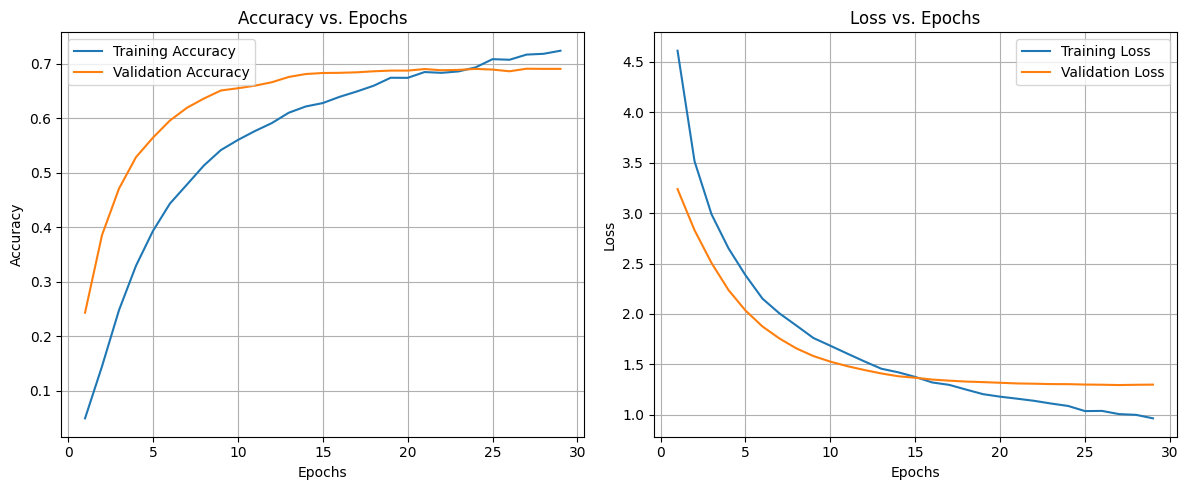

In [77]:
# Step 2: Build Classifier
def build_classifier_pca(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.8),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Step 5: Train Classifier on Latent Features
classifier_pca = build_classifier_pca(train_pca.shape[1], num_classes_eigen)
classifier_pca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping_pca = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

print("Training Classifier on Latent Features...")
history_pca=classifier_pca.fit(
    train_pca, train_labels_eigen,
    validation_data=(val_pca, val_labels_eigen),
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping_pca]
)

# Step 6: Evaluate Recognition Accuracy
print("Evaluating Classifier...")
test_predictions_pca = classifier_pca.predict(test_pca)
test_predictions_labels_pca = test_predictions_pca.argmax(axis=1)
test_true_labels_pca = test_labels_eigen.argmax(axis=1)

recognition_accuracy_pca = accuracy_score(test_true_labels_pca, test_predictions_labels_pca)
print(f"Face Recognition Accuracy: {recognition_accuracy_pca * 100:.2f}%")

# Call the plot function with the training history
plot_training_metrics2(history_pca)

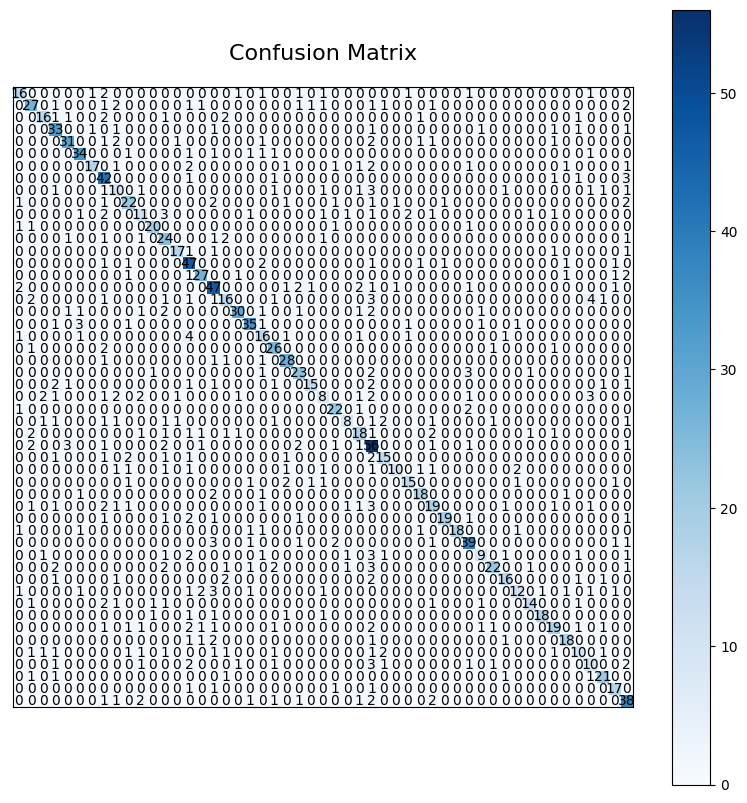

In [78]:
plot_confusion_matrix(test_true_labels_pca, test_predictions_labels_pca)

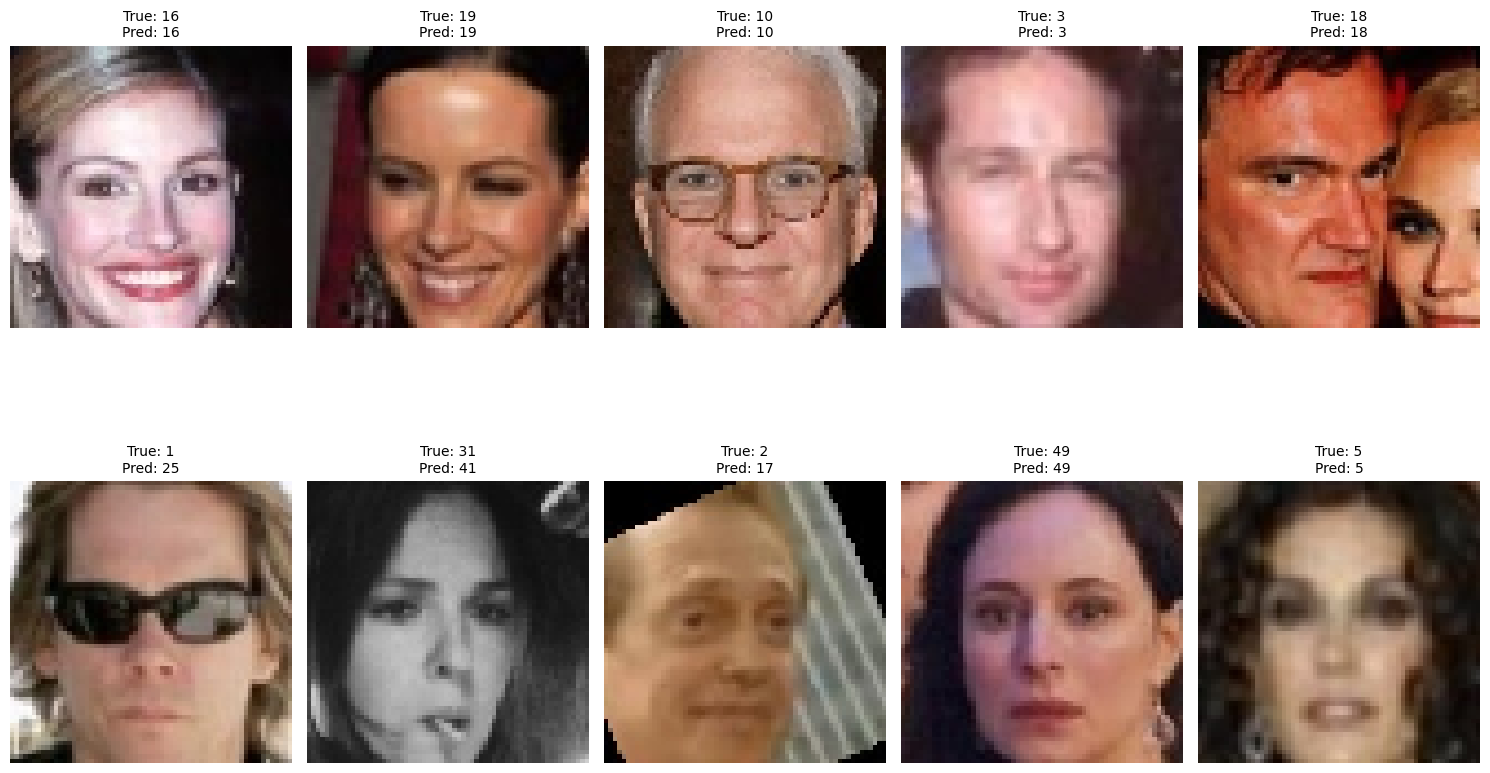

In [80]:
visualize_predictions(test_images, test_true_labels_pca, test_predictions_labels_pca, num_images_to_display=10)

# Comaprison

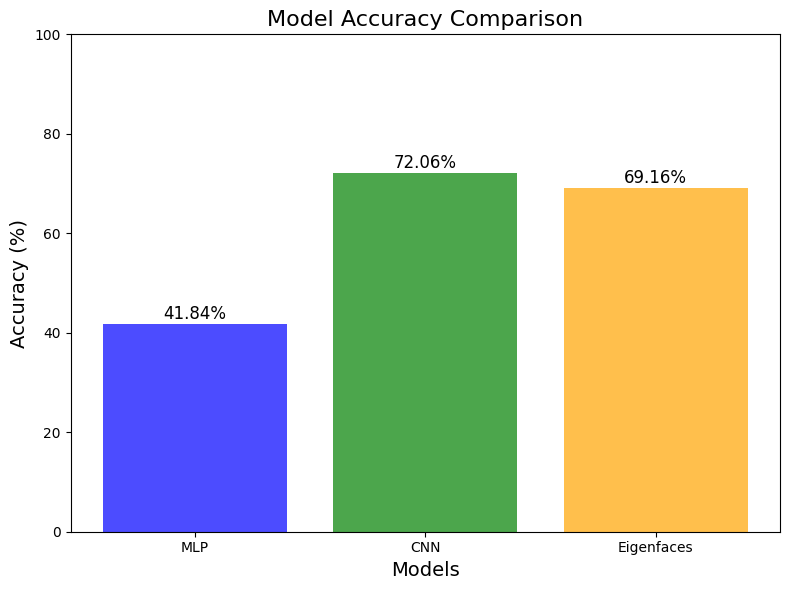

In [81]:
model_names = ["MLP", "CNN", "Eigenfaces"]
accuracies = [recognition_accuracy_mlp, recognition_accuracy_cnn, recognition_accuracy_pca]

visualize_model_accuracies(model_names, accuracies)